2.0 did a great analysis and showed comprable recalls. But that is because of 'offsetting' signals from sicker black patients (higher death rates, higher risk scores) vs worse model AUC for black patients than white patients (64.8 vs 71.5).

Can we augment the task with additional feature data to help close the AUC gap and improve predictions for black patients? Would be very useful if the model was essentially thermostatic: sicker patients get more help.

In [1]:
import psycopg2
import pandas as pd
import tqdm
from collections import Counter, defaultdict
import pylab as pl
import random
import xgboost
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.calibration import calibration_curve
from scipy.stats import mannwhitneyu
from lifelines import KaplanMeierFitter
import re

pd.set_option('display.max_columns', None)

In [2]:
# create a database connection
sqluser = 'wboag'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host="/var/run/postgresql")

# Cohort Creation

In [4]:
# TODO: exclude patients who die in-hospital
cohort_query = '''
WITH T AS (
        SELECT subject_id, MAX(admittime) AS admittime
        FROM mimiciii.admissions 
        GROUP BY subject_id
        ),
     EOL as (
         select hadm_id
         from mimiciii.diagnoses_icd
         where icd9_code = 'V667'
     )
SELECT a.*, gender, dob, dod
FROM mimiciii.admissions a
    JOIN T ON T.subject_id = a.subject_id AND T.admittime = a.admittime
    JOIN mimiciii.patients  p on p.subject_id = a.subject_id
where a.hadm_id not in (select hadm_id from EOL)
and ((dod is null) or (dod :: date - dischtime ::date >= 3))
and a.discharge_location not in ('HOSPICE-HOME', 'HOSPICE-MEDICAL FACILITY', 'DEAD/EXPIRED')
and dod is not null
and (a.admittime :: date - dob ::date) / 365.25 >= 18
--and insurance = 'Medicare'
'''
cohort = pd.read_sql_query(cohort_query, con)
print(cohort.shape)
cohort.head()

(9165, 22)


In [4]:
codestatus_df = pd.read_sql_query('select * from mimiciii.code_status', con)

# get code statuses
codestatus = {}
for row in codestatus_df.itertuples():
    if row.fullcode_last == 1:
        cs = 'fullcode'
    elif row.cmo_last == 1:
        cs = 'cmo'
    elif row.dnr_last == 1:
        cs = 'dnr'
    elif row.dni_last == 1:
        cs = 'dni'
    elif row.dncpr_last == 1:
        cs = 'dncpr'
    else:
        cs = 'none'
        
    codestatus[row.hadm_id] = cs

In [5]:
cmo = set([hadm_id for hadm_id,cs in codestatus.items() if cs=='cmo'])
print(len(cmo))

cohort = cohort[~cohort.hadm_id.isin(cmo)]
print(cohort.shape)

1615
(9144, 22)


In [5]:
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,ethnicity FROM mimiciii.icustay_detail;' 
demographics = pd.read_sql_query(demographics_query, con)

# filter demographics to the patients in the cohort
demographics = demographics[demographics.hadm_id.isin(set(cohort.hadm_id))]

print(demographics.shape)
demographics.head()

(9018, 4)


In [7]:
def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

demographics['race'] = demographics['ethnicity'].apply(normalize_race)

race_lookup = defaultdict(lambda:'unk')
race_lookup.update(dict(demographics[['hadm_id','race']].values))

In [8]:
# Severity of Illness

oasis = pd.read_sql_query('select hadm_id,oasis from mimiciii.oasis', con)
oasis = oasis[oasis.hadm_id.isin(set(cohort.hadm_id))]
oasis_lookup = dict(oasis[['hadm_id','oasis']].values)

saps = pd.read_sql_query('select hadm_id,sapsii from mimiciii.sapsii', con)
saps = saps[saps.hadm_id.isin(set(cohort.hadm_id))]
saps_lookup = dict(saps[['hadm_id','sapsii']].values)

sofa = pd.read_sql_query('select hadm_id,sofa from mimiciii.sofa', con)
sofa = sofa[sofa.hadm_id.isin(set(cohort.hadm_id))]
sofa_lookup = dict(sofa[['hadm_id','sofa']].values)

# Feature and Labels

In [9]:
# identify who dies within 6 months
died_within_6months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=180)]
died_within_12months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=365)]
died_postdisch = cohort[~cohort.dod.isnull()]

# label every patient as dying within 6 months or not
labels = {hadm_id:0 for hadm_id in cohort.hadm_id}
#for hadm_id in died_within_6months.hadm_id:
for hadm_id in died_within_12months.hadm_id:
#for hadm_id in died_postdisch.hadm_id:
    labels[hadm_id] = 1

print(len(labels))

# print positive percentage
print(sum(labels.values()) / len(labels))

9144
0.5138888888888888


In [10]:
print(len(labels))
print(len(set(demographics.hadm_id)))
print(len(set(cohort.hadm_id)))


9144
8997
9144


Text(0, 0.5, '% Patients Still Alive')

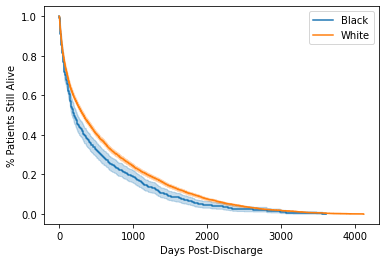

In [11]:
#died_postdisch
died_postdisch['race']  = [race_lookup[row.hadm_id] for row in died_postdisch.itertuples()]
ax = pl.subplot(111)
for race,rows in died_postdisch.groupby('race'):
    if race not in ['White', 'Black']: continue
        
    #print(race)
    #display(rows)
    times  = [t.days for t in (rows.dod - rows.dischtime)]
    
    kmf = KaplanMeierFitter()
    kmf.fit(durations = times, label=race)
    
    kmf.plot_survival_function(ax = ax)

#pl.title('Survival Analysis Post-Discharge')
pl.xlabel('Days Post-Discharge')
pl.ylabel('% Patients Still Alive')

In [12]:
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian']:
    rows = demographics[demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_labels   = [labels[pid] for pid in group_ids]
    print(f'{race:15} {sum(group_labels):4}/{len(group_labels):5} ({sum(group_labels)/len(group_labels):.3f})')

print()
print(f'{"all":15} {sum(labels.values()):4}/{len(labels):5} ({sum(labels.values())/len(labels):.3f})')

White           3492/ 6654 (0.525)
Not Specified    420/ 1086 (0.387)
Black            370/  602 (0.615)
Other            171/  320 (0.534)
Hispanic          81/  177 (0.458)
Asian            104/  153 (0.680)

all             4699/ 9144 (0.514)


In [13]:
# Get ICD codes
icd_query = '''
select icd.hadm_id, icd.icd9_code
from mimiciii.DIAGNOSES_ICD icd
inner join mimiciii.d_icd_diagnoses d on d.icd9_code = icd.icd9_code
--limit 500
'''
icd_df = pd.read_sql_query(icd_query, con)
icd_df = icd_df[icd_df.hadm_id.isin(set(cohort.hadm_id))]
print(icd_df.shape)
print(len(set(icd_df.hadm_id)))
icd_df.head()

(108681, 2)
9143


,hadm_id,icd9_code
42,114585,1940
43,114585,1977
44,114585,2553
45,114585,4240
46,114585,5845


In [14]:
d_icd = pd.read_sql_query('select * from mimiciii.d_icd_diagnoses', con)
icd_lookup = dict(d_icd[['icd9_code','long_title']].values)
#icd_lookup = {str(k):v for k,v in icd_df[['icd9_code','short_title']].values}
dict(list(icd_lookup.items())[:3])

{'01166': 'Tuberculous pneumonia [any form], tubercle bacilli not found by bacteriological or histological examination, but tuberculosis confirmed by other methods [inoculation of animals]',
 '01170': 'Tuberculous pneumothorax, unspecified',
 '01171': 'Tuberculous pneumothorax, bacteriological or histological examination not done'}

(0.0, 100.0, 0.0, 1000.0)

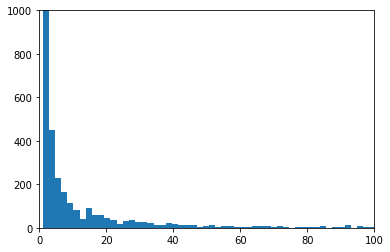

In [15]:
# Frequency of ICDs
icd_freq = Counter(icd_df.icd9_code)

pl.hist(icd_freq.values(), bins=2000)
pl.axis([0, 100, 0, 1000])

Inspiration

per Neto et al 2018 (includes Alistair) https://link.springer.com/article/10.1007/s00134-018-5375-6
- Data was extracted from the database using structured query language (SQL), and included VT, positive end–expiratory pressure (PEEP), peak pressure (Ppeak) and Pplat, RR, and the inspired fraction of oxygen (FiO2).
- For patients who received ventilation in a volume–controlled assist mode, driving pressure (ΔP) was calculated as Pplat minus PEEP.
- The following demographic data (using first 24 hours of admission data) were collected: age, gender, ethnicity (white, black, Hispanic or Latino, or other), height, weight, comorbidities (using the Elixhauser comorbidity score for the MIMIC–III database),4,5 active smoking status (by Natural Language Processing searches in provider notes, categorized as ‘yes’, ‘no’, or ‘unknown’), primary diagnoses category on hospital discharge using the primary International Classification of Diseases (ICD)–9 diagnosis, and disease severity scores (Simplified Acute Physiology Score [SAPS] II,6 Sequential Organ Failure Assessment [SOFA],7 the Oxford Acute Severity of Illness Score [OASIS],8 and the Acute Physiology And Chronic Health Evaluation [APACHE] IV).9
- Vital signs and laboratory measurements were captured as lowest and the highest values in the first and in the second day of ventilation. Use of vasopressors and need of renal replacement therapy during the first 24 hours of admission was collected, as was the latest code status of each patient. Presence of ARDS was scored according to the Berlin definition in the first 48 hours of ventilation.10

In [16]:
def icd9_to_elixhauser(codes):
    # https://cdn.jamanetwork.com/ama/content_public/journal/jamanetworkopen/938206/zoi190606supp1_prod.pdf?Expires=1648056572&Signature=XEmoCvKY8BgPfGQHBj3HXaoja9~-RwTpNxTy-cTvG0TLYymWZ0IDVcXvZX20XHyrd-~H9yDI-s0Yhy3l6FBnlIou8EZOdLyWMuhmUs5Shvtk8Ut48qmcKpjNSmafZJ02jt4dZziA~jB4J06eqoAbNIYNb6LCow0IcraK9mvwmXP-iFXQGzqE7myn1fz9pI3jgsbAtKDnKYzzNbil3qslZevEVG94ujLBKSlveFaFObFmqb4qsZFk7et3yJC6xQamOoV6XcieNNLzKgkUyGBRhxWBUeifWx33As10hxd2IZ~iKyyGZvItNlfgZyrByGNrGTZ8HM~eZzh6x0eVraEcJg__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA
    
    mapping = {
        'Alcohol abuse' : ['2652', '291[12356789]', '303[09]', '3050', '3575', '4255', '5353', '571[0123]', '980', 'V113'] ,
        'Cardiac arrhythmias': ['426([079]|1[023])', '427[01234]', 'V450', 'V533'],
        'Blood loss anemia' : ['2800'] ,
        'Congestive heart failure':['39891', '402(01|11|91)', '404(01|03|[19][13])', '42(5[456789]|8)'],
        'Chronic pulmonary disease':['416[89]', '49', '50([012345]|64|8[18])'],
        'Coagulopathy':['286', '2871', '287[345]'],
        'Deficiency anemia':['280[123456789]', '281'],
        'Depression':['296[235]', '3004', '309', '311'],
        'Diabetes complicated':['250[456789]'],
        'Diabetes uncomplicated':['250[0123]'],
        'Drug abuse':['292', '304', '305[23456789]', 'V6542'],
        'Fluid and electroylte disorders':['2536', '276'],
        'AIDS/HIV':['B20'],
        'Hypertension, complicated':['40[2345]'],
        'Hypertension, uncomplicated':['401'],
        'Hypothyroidism':['2409', '24([34]|6[18])'],
        'Liver disease':['070([23]|[45])', '456[012]', '57([01]|2[2345678]|3[3489])', 'V427'],
        'Lymphoma':['20[012]', '2030', '2386'] ,
        'Metastatic cancer':['19[6789]'],
        'Obesity':['2780'],
        'Other neurological disorders':['3319', '332[01]', '333[45]', '33([45]|62)', '34([015]|8[13])', '78[04]3'],
        'Pulmonary circulation disorder':['415[01]', '416', '417[089]'],
        'Peptic ulcer disease excluding bleeding':['53[1234][79]'],
        'Pulmonary valvular disorder':['0930', '4373', '44([01]|3[123456789])', '4471', '557[19]', 'V434'],
        'Paralysis':['3341', '34([23]|4[01234569])'] ,
        'Psychoses':['2938', '296[0145]4', '29[578]'] ,
        'Renal failure':['403', '404', '58([56]|80)', 'V4(20|51)', 'V56'],
        'Rheumatoid arthritis/collagen vascular diseases':['446', '7010', '71(0[0123489]|12|4|93)', '72([05]|8[58]|93)'],
        'Solid tumor without metastasis':['1[456]', '17[012456789]', '18', '19([012345])'],
        'Valvular disease':['0932', '39[4567]', '424', '746[3456]', 'V422', 'V433'],
        'Weight loss':['26[0123]', '7832', '7994'],
    }
    
    comorbidities = defaultdict(int)
    for code in codes:
        for cm,regxs in mapping.items():
            for regx in regxs:
                if re.search(f'^{regx}', code):
                    comorbidities[cm] += 1
                    
    return comorbidities
                
icd9_to_elixhauser(['V113', '3030', '3031', '4261', '4267'])


defaultdict(int, {'Alcohol abuse': 2, 'Cardiac arrhythmias': 1})

In [17]:
features = {}
for hadm_id,rows in tqdm.tqdm(icd_df.groupby('hadm_id')):
    feats = {}
    
    # ICD features
    for icd in rows.icd9_code:
        if icd_freq[icd] > 5:
            #feats[icd] = 1
            
            # Elixhauser Comorbidities
            codes = list(map(str,rows.icd9_code))
            elixhausers = icd9_to_elixhauser(codes)
            for cm,count in elixhausers.items():
                feats[f'elixhausers={cm}'] = 1
            
    # demographic features
    drows = demographics[demographics.hadm_id==hadm_id]
    if len(drows):
        feats[    f'race={drows.race.values[0]}'] = 1
        feats[f'gender={drows.gender.values[0]}'] = 1
    crows = cohort[cohort.hadm_id==hadm_id]
    feats['age'] = (crows.admittime.values[0] - crows.dob.values[0]) / (np.timedelta64(1, 'D') * 365.25)
    
    # Admission data
    for col in ['admission_type','admission_location','discharge_location','insurance','religion','marital_status']:
        value = crows[col].values[0]
        feats[f'{col}={value}'] = 1
    
    # get severity scores at time of discharge
    if hadm_id in  saps_lookup: feats['saps']  =  saps_lookup[hadm_id] /  64
    if hadm_id in  sofa_lookup: feats['sofa']  =  sofa_lookup[hadm_id] / 110
    if hadm_id in oasis_lookup: feats['oasis'] = oasis_lookup[hadm_id] /  19
    
    # code status
    if hadm_id in codestatus: feats[f'codestatus={codestatus[hadm_id]}'] = 1 

    # TODO: add labs
    pass
        
    # TODO: add another set of data (eg chartevents interpersonal stuff?)
    pass
    
    features[hadm_id] = feats
    
print(len(features))

100%|██████████| 9143/9143 [02:11<00:00, 69.62it/s] 

9143


In [18]:
list(features.items())[:3]

[(100016,
  {'elixhausers=Other neurological disorders': 1,
   'race=White': 1,
   'gender=M': 1,
   'age': 55.549440639269406,
   'admission_type=EMERGENCY': 1,
   'admission_location=CLINIC REFERRAL/PREMATURE': 1,
   'discharge_location=SNF': 1,
   'insurance=Medicare': 1,
   'religion=PROTESTANT QUAKER': 1,
   'marital_status=SINGLE': 1,
   'saps': 0.625,
   'sofa': 0.045454545454545456,
   'oasis': 2.0526315789473686,
   'codestatus=none': 1}),
 (100036,
  {'elixhausers=Valvular disease': 1,
   'elixhausers=Congestive heart failure': 1,
   'elixhausers=Fluid and electroylte disorders': 1,
   'elixhausers=Cardiac arrhythmias': 1,
   'elixhausers=Renal failure': 1,
   'elixhausers=Hypertension, complicated': 1,
   'elixhausers=Pulmonary valvular disorder': 1,
   'race=White': 1,
   'gender=F': 1,
   'age': 82.92488203957382,
   'admission_type=EMERGENCY': 1,
   'admission_location=TRANSFER FROM HOSP/EXTRAM': 1,
   'discharge_location=SNF': 1,
   'insurance=Medicare': 1,
   'religion=

# ML Model

In [19]:
ids = list(set(features.keys()) & set(labels.keys()))
random.shuffle(ids)

ind = int(0.7 * len(ids))
train_ids = ids[:ind]
test_ids  = ids[ ind:]

print(len(train_ids), len(test_ids))

6400 2743


In [20]:
train_features = [features[hadmid] for hadmid in train_ids]
test_features  = [features[hadmid] for hadmid in  test_ids]

train_labels = [labels[hadmid] for hadmid in train_ids]
test_labels  = [labels[hadmid] for hadmid in  test_ids]

In [21]:
vect = DictVectorizer()
vect.fit(train_features)

DictVectorizer()

In [22]:
train_X = vect.transform(train_features)
test_X  = vect.transform( test_features)

print(train_X.shape)
print(test_X.shape)

(6400, 104)
(2743, 104)


In [23]:
xgb = xgboost.XGBClassifier(eval_metric='logloss')
xgb.fit(train_X, train_labels)

/afs/csail.mit.edu/u/w/wboag/.conda/envs/wb/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluation

In [24]:
def evaluate_performance(labels, preds, thr=None):
    #print('AAA:', len(labels), len(preds))
    
    if not thr:
        n = int(0.9*len(preds))
        thr = sorted(preds)[n]
        
    preds_thr = [int(p>=thr) for p in preds]
    
    # confusion matrix
    tp,fp,fn,tn = 0,0,0,0
    for ref,pred in zip(labels,preds_thr):
        if   ref==0 and pred==0: tn += 1
        elif ref==0 and pred==1: fp += 1
        elif ref==1 and pred==0: fn += 1
        elif ref==1 and pred==1: tp += 1
    conf = {'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn}
    recall    = float(tp) / (tp+fn+1e-9)
    precision = float(tp) / (tp+fp+1e-9)
    #print(conf)
    #print(recall)
    
    # AUC
    #print(labels)
    #print(preds)
    auc = roc_auc_score(labels, preds)
            
    results = {'recall':recall, 'precision':precision, 'auc':auc, 'conf':conf}
    return results

In [25]:
test_pred = xgb.predict_proba(test_X)[:,1]

print(test_pred.shape)

(2743,)


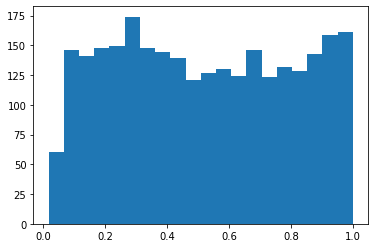

In [26]:
pl.hist(test_pred, bins=20)
pl.show()

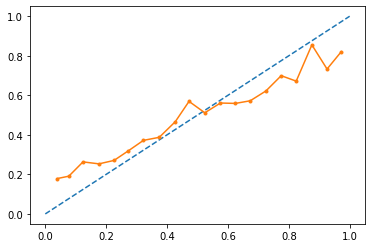

In [27]:
# reliability diagram
fop, mpv = calibration_curve(test_labels, test_pred, n_bins=20)
# plot perfectly calibrated
pl.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pl.plot(mpv, fop, marker='.')
pl.show()

In [28]:
# Overall AUC
roc_auc_score(test_labels, test_pred)

0.7236296005640147

White           (n=2008) R=162/1032(0.157)   P=162/ 207(0.783)   AUC=0.723


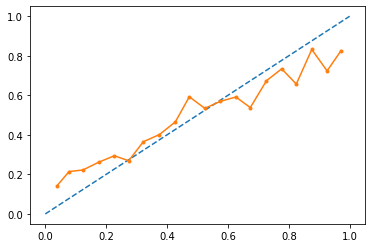

Not Specified   (n= 302) R= 10/ 115(0.087)   P= 10/  11(0.909)   AUC=0.709


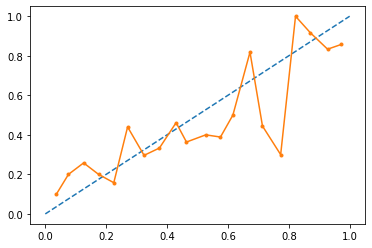

Black           (n= 181) R= 20/ 115(0.174)   P= 20/  23(0.870)   AUC=0.702


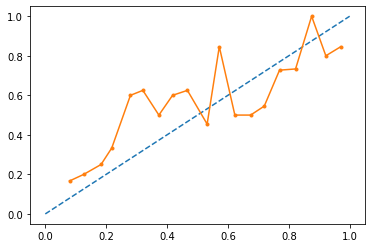

Other           (n=  96) R=  8/  44(0.182)   P=  8/   9(0.889)   AUC=0.727


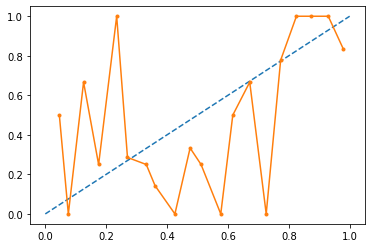

Hispanic        (n=  53) R=  4/  22(0.182)   P=  4/   6(0.667)   AUC=0.645


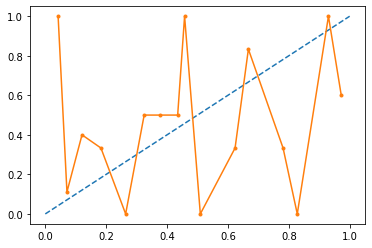

Asian           (n=  57) R= 11/  38(0.289)   P= 11/  17(0.647)   AUC=0.607


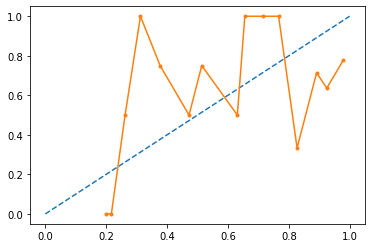

In [29]:
# Per race recall @ top-10%
n = int(0.9*len(test_pred))
thr = sorted(test_pred)[n]

test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian']:
    #print(race)
    #display(rows)
    rows = test_demographics[test_demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_features = [features[pid] for pid in group_ids]
    group_X = vect.transform(group_features)
    group_labels   = [labels[pid]   for pid in group_ids]
    group_pred = xgb.predict_proba(group_X) [:,1]
    
    results = evaluate_performance(group_labels, group_pred, thr=thr)
    conf = results['conf']
    tp,fp,fn,tn = conf['TP'], conf['FP'], conf['FN'], conf['TN']
    auc       = results['auc']
    precision = results['precision']
    recall    = results['recall']
    
    print(f'{race:15} (n={len(group_ids):4}) R={tp:3d}/{tp+fn:4}({recall:.3f})   P={tp:3d}/{tp+fp:4}({precision:.3f})   AUC={auc:.3f}')

    # reliability diagram
    fop, mpv = calibration_curve(group_labels, group_pred, n_bins=20)
    # plot perfectly calibrated
    pl.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pl.plot(mpv, fop, marker='.')
    pl.show()
    
    #break

In [30]:
# Most informative features
svm = LinearSVC()
svm.fit(train_X, train_labels)

# map the dimensions to names
ind2feat =  { i:f for f,i in vect.vocabulary_.items() }

# create a 2-by-m matrix for biary, rather than relying on 1-p bullshit
coef_ = svm.coef_[0,:]

# most informative features
informative_feats = np.argsort(coef_)

#'''
# display what each feature is
for dim in list(reversed(informative_feats))[:25]:
    val = coef_[dim]

    word = ind2feat[dim]
    if word in icd_lookup:
        desc = icd_lookup[word]
    else:
        desc = word
        word = ''
    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}]: {val}')
    
print('\n')

for dim in list(reversed(informative_feats))[-25:]:
    val = coef_[dim]

    word = ind2feat[dim]
    if word in icd_lookup:
        desc = icd_lookup[word]
    else:
        desc = word
        word = ''
    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}]: {val}')

[.     ] [religion=BUDDHIST                                   ]: 0.7780840367315294
[.     ] [elixhausers=Metastatic cancer                       ]: 0.623716667323347
[.     ] [discharge_location=SHORT TERM HOSPITAL              ]: 0.5144376066987726
[.     ] [codestatus=dncpr                                    ]: 0.486970118153934
[.     ] [sofa                                                ]: 0.4238998363262326
[.     ] [saps                                                ]: 0.3187777038140298
[.     ] [race=Asian                                          ]: 0.31595954071430127
[.     ] [religion=JEHOVAH'S WITNESS                          ]: 0.3086131618841077
[.     ] [elixhausers=Solid tumor without metastasis          ]: 0.27439553721014776
[.     ] [race=Other                                          ]: 0.2305155598953253
[.     ] [discharge_location=LONG TERM CARE HOSPITAL          ]: 0.2143586990777015
[.     ] [elixhausers=Fluid and electroylte disorders         ]: 0.206233685

/afs/csail.mit.edu/u/w/wboag/.conda/envs/wb/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [38]:
# Run multiple times
aucs       = defaultdict(list)
recalls    = defaultdict(list)
precisions = defaultdict(list)
scores = defaultdict(list)
for i in tqdm.tqdm(range(20)):
    # Randomly split data
    ids = list(set(features.keys()) & set(labels.keys()))
    random.shuffle(ids)
    ind = int(0.7 * len(ids))
    train_ids = ids[:ind]
    test_ids  = ids[ ind:]

    # train/test separation
    train_features = [features[hadmid] for hadmid in train_ids]
    test_features  = [features[hadmid] for hadmid in  test_ids]

    train_labels = [labels[hadmid] for hadmid in train_ids]
    test_labels  = [labels[hadmid] for hadmid in  test_ids]
    
    # vectorizer
    vect = DictVectorizer()
    vect.fit(train_features)
    train_X = vect.transform(train_features)
    test_X  = vect.transform( test_features)
    
    # fit model
    xgb = xgboost.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    xgb.fit(train_X, train_labels)
    
    # threshold across groups
    test_pred = xgb.predict_proba(test_X) [:,1]
    n = int(0.9*len(test_pred))
    thr = sorted(test_pred)[n]
    
    # overall
    
    # predict and eval for black vs white
    test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
    for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian', 'All']:
        if race == 'All':
            rows = test_demographics
        else:
            rows = test_demographics[test_demographics.race==race]
            
        group_ids = list(set(rows.hadm_id))
        group_features = [features[pid] for pid in group_ids]
        group_X = vect.transform(group_features)
        group_labels   = [labels[pid]   for pid in group_ids]
        group_pred = xgb.predict_proba(group_X) [:,1]
        
        # Collect all risk scores across all 20 runs (cuz plotting median)
        scores[race] += list(group_pred)

        results = evaluate_performance(group_labels, group_pred, thr=thr)
        aucs[race].append(results['auc'])
        recalls[race].append(results['recall'])
        precisions[race].append(results['precision'])


print('AUC')
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian', 'All']:
    print(f'\t{race:15}: ${np.mean(aucs[race]):6.3f} \pm {np.std(aucs[race]):6.3f}$')
    #for auc in aucs[race]:
    #    print(f'\t{auc}')
    #print()
print()
    
print('Recall')
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian', 'All']:
    print(f'\t{race:15}: ${np.mean(recalls[race]):6.3f} \pm {np.std(recalls[race]):6.3f}$')
    #for r in recalls[race]:
    #    print(f'\t{r}')
    #print()
print()
    
print('Precision')
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian', 'All']:
    print(f'\t{race:15}: ${np.mean(precisions[race]):6.3f} \pm {np.std(precisions[race]):6.3f}$')
    #for r in recalls[race]:
    #    print(f'\t{r}')
    #print()

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

AUC
	White          : $ 0.715 \pm  0.010$
	Not Specified  : $ 0.701 \pm  0.021$
	Black          : $ 0.675 \pm  0.023$
	Other          : $ 0.714 \pm  0.047$
	Hispanic       : $ 0.694 \pm  0.082$
	Asian          : $ 0.658 \pm  0.095$
	All            : $ 0.715 \pm  0.008$

Recall
	White          : $ 0.163 \pm  0.007$
	Not Specified  : $ 0.095 \pm  0.022$
	Black          : $ 0.201 \pm  0.039$
	Other          : $ 0.158 \pm  0.047$
	Hispanic       : $ 0.148 \pm  0.077$
	Asian          : $ 0.318 \pm  0.082$
	All            : $ 0.163 \pm  0.004$

Precision
	White          : $ 0.839 \pm  0.022$
	Not Specified  : $ 0.805 \pm  0.103$
	Black          : $ 0.835 \pm  0.064$
	Other          : $ 0.921 \pm  0.085$
	Hispanic       : $ 0.706 \pm  0.197$
	Asian          : $ 0.827 \pm  0.111$
	All            : $ 0.835 \pm  0.019$


		white: 1994.95 0.52083117
		black: 185.2 0.63419855
		asian: 44.55 0.7608273


<ipython-input-41-0a83c41dcdb9>:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pl.subplot(111)


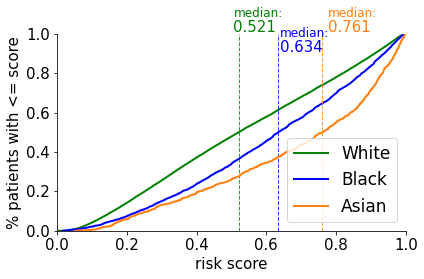

In [41]:
def list_median(vals):
    svals = sorted(vals)
    return svals[int(len(svals)/2)]


def plot_distributions(dists):
    fig = pl.figure()

    p1 = list(dists['White'])
    p2 = list(dists['Black'])
    p3 = list(dists['Asian'])
    
    white_median = list_median(p1)
    black_median = list_median(p2)
    asian_median = list_median(p3)
    smallest_median = min(white_median, black_median, asian_median)
    largest_median  = max(white_median, black_median, asian_median)

    #colors = ['#00A6ED', '#FF5400']
    colors = ['green', 'blue', 'tab:orange']
    for i,race in enumerate(['White', 'Black', 'Asian']):
        vals = list(dists[race])
        pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label=race, lw=2)
        #pl.xlim((0,0.4))
        pl.xlim((0,1.0))
        pl.ylim((0,1.0))

        median = list_median(vals)
        pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == smallest_median:
            p = -.015
            yoffset = 0
        elif median == largest_median:
            p = .015
            yoffset = 0
        else:
            p = .005
            yoffset = -.1
        h = 'left'
        #h = 'center'
        pl.text(x=median+p, y=1.085+yoffset, horizontalalignment=h, s="median:"      , fontsize=12, color=colors[i])
        pl.text(x=median+p, y=1.01 +yoffset, horizontalalignment=h, s=f'{median:.3f}', fontsize=15, color=colors[i])


    ax = pl.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    pl.yticks(fontsize=15)    
    pl.xticks(fontsize=15) 

    pl.legend(loc=4, fontsize=17)
    pl.ylabel("% patients with <= score", fontsize=15)
    pl.xlabel('risk score', fontsize=15)

    pl.tight_layout()

    w = mannwhitneyu(p1, p2)
    print('\t\twhite:', len(p1)/20, white_median)
    print('\t\tblack:', len(p2)/20, black_median)
    print('\t\tasian:', len(p3)/20, asian_median)
    pl.show()
    

    
plot_distributions(scores)